In [1]:
import warnings
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import math
import bisect

sys.path.insert(0, '../../..')

from cde.density_estimator import ExtremeValueMixtureDensityNetwork
from cde.density_estimator import MixtureDensityNetwork

from cde.data_collector import MatlabDataset, MatlabDatasetH5
from cde.density_estimator import plot_conditional_hist, measure_percentile, measure_percentile_allsame, measure_tail, measure_tail_allsame, init_tail_index_hill, estimate_tail_index_hill


/Users/ssmos/.pyenv/versions/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ssmos/.pyenv/versions/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ssmos/.pyenv/versions/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ssmos/.pyenv/versions/venv/lib/python3.6/s

In [2]:
""" Open MATLAB file """

#matds = MatlabDataset('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
#matds = MatlabDataset('../../data/dataset_normal_400k.mat')
matds = MatlabDataset('../../data/fulldataset_gamma_400k.mat') 


dataset loaded from .mat file. Rows: 399997   Columns: 4 


In [198]:
""" Take conditioned samples and fit tail density model """

train_data = matds.get_data(40000) #40k

Y = train_data[:,0]
X = train_data[:,1:]

print("Number of negative values in Y: " + str(np.size(np.where(Y < 0))))
print("Are there any NaN values in Y: " + str(np.isnan(Y).any()))

# epochs 10000, 1000
model = ExtremeValueMixtureDensityNetwork("GMM_powerlaw_mixture2", ndim_x=3, n_centers=10, ndim_y=1, n_training_epochs=10000, hidden_sizes=(32, 32),verbose_step=1000,learning_rate=1e-3)

model.fit(X, Y)

Number of negative values in Y: 0
Are there any NaN values in Y: False
Step 0: train log-likelihood 176725.53
Step 1000: train log-likelihood 49421.586
Step 2000: train log-likelihood 49243.695
Step 3000: train log-likelihood 49176.477
Step 4000: train log-likelihood 49137.414
Step 5000: train log-likelihood 49113.984
Step 6000: train log-likelihood 49119.992
Step 7000: train log-likelihood 49124.65
Step 8000: train log-likelihood 49125.965
Step 9000: train log-likelihood 49119.938
Step 10000: train log-likelihood 49109.324


In [4]:
""" verbose function """

mx = np.array([[0,1,1],[0,1,1],[0,1,1],[0,1,1],[0,1,1]])
my = np.array([[7],[5.2],[6.44],[2],[10]])
model._verbose(mx,my)

[[0 1 1]
 [0 1 1]
 [0 1 1]
 [0 1 1]
 [0 1 1]]
[ 7.    5.2   6.44  2.   10.  ]
[[0.01166205 0.10457125 0.49881774 0.5419307  0.58304745]
 [0.01166205 0.10457125 0.49881774 0.5419307  0.58304745]
 [0.01166205 0.10457125 0.49881774 0.5419307  0.58304745]
 [0.01166205 0.10457125 0.49881774 0.5419307  0.58304745]
 [0.01166205 0.10457125 0.49881774 0.5419307  0.58304745]]
[[2.7190952e-04 1.1029254e-01 9.0548992e-06 1.2418067e-05 8.8941413e-01]
 [2.7190952e-04 1.1029254e-01 9.0548992e-06 1.2418067e-05 8.8941413e-01]
 [2.7190952e-04 1.1029254e-01 9.0548992e-06 1.2418067e-05 8.8941413e-01]
 [2.7190952e-04 1.1029254e-01 9.0548992e-06 1.2418067e-05 8.8941413e-01]
 [2.7190952e-04 1.1029254e-01 9.0548992e-06 1.2418067e-05 8.8941413e-01]]
[[5.852482  4.378547  3.746439  3.939691  3.1255827]
 [5.852482  4.378547  3.746439  3.939691  3.1255827]
 [5.852482  4.378547  3.746439  3.939691  3.1255827]
 [5.852482  4.378547  3.746439  3.939691  3.1255827]
 [5.852482  4.378547  3.746439  3.939691  3.1255827]]

In [17]:
""" test parameters """

mx = np.array([[0,1,1]])
#my = np.array([7])
weights, locs, scales = model._get_mixture_components(mx)
threshold, tail_param = model._get_tail_components(mx)
print("mixture weigths: "+str(weights)+", mixture locations: "+str(locs)+", mixture scales: "+str(scales)+", tail threshold: "+str(threshold)+" tail index: "+str(1/tail_param))

mixture weigths: [[0.00070524 0.00133336 0.00102995 0.05198918 0.69002086 0.00221135
  0.00445496 0.00107086 0.21719004 0.02999414]], mixture locations: [[[2.2153049]
  [2.921678 ]
  [2.1406946]
  [4.411988 ]
  [3.1942236]
  [5.602779 ]
  [2.1840353]
  [2.3788474]
  [3.8831136]
  [2.5458584]]], mixture scales: [[[0.01999543]
  [0.1331521 ]
  [0.0119356 ]
  [0.76883745]
  [0.5977846 ]
  [0.44693494]
  [0.16924313]
  [0.09688339]
  [0.718185  ]
  [0.18025376]]], tail threshold: [[5.6750164]] tail index: [[18.967672]]


In [5]:
""" test prob function """

mx = np.array([[0,1,1]])
my = np.array([[10]])
print(model.pdf(mx,my))

[4.2349207e-08]


In [7]:
""" test tail prob """

cond_state = [0,1,1]
mx = np.array([cond_state])
my = np.array([11])
print(model.tail(mx,my))


2.1716493e-09


In [200]:
""" Take conditioned samples and fit a Gaussian Mixture Model """
from cde.density_estimator import MixtureDensityNetwork

N_tr = len(train_data)

Y = train_data[:,0]
X = train_data[:,1:]

gmm_model = MixtureDensityNetwork("GMM_3hop_gamma2", ndim_x=3, n_centers=10, ndim_y=1,n_training_epochs=10000,hidden_sizes=(32, 32))
gmm_model.fit(X, Y)

10000/10000 [100%] ██████████████████████████████ Elapsed: 1913s | loss: 43814.855
mean log-loss train: 1.0954


In [199]:
""" Save the trained EVMDN model and the training data into file """

with open('saves/EVMDN_3hop_gamma_40k_3dim_10kepoch.pkl', 'wb') as output:
    pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

np.save('saves/EVMDN_3hop_gamma_40k_3dim_10kepoch.npy', train_data)

In [201]:
""" Save the trained GMM model and the training data into file """

with open('saves/EVMDN_gmm_3hop_gamma_40k_3dim_10kepoch.pkl', 'wb') as output:
    pickle.dump(gmm_model, output, pickle.HIGHEST_PROTOCOL)

np.save('saves/EVMDN_3hop_gamma_40k_3dim_10kepoch.npy', train_data)

In [3]:
""" Load the trained EVMDN model and training dataset from file """

dummy = ExtremeValueMixtureDensityNetwork("GMM_powerlaw_mixture", ndim_x=3, n_centers=10, ndim_y=1, n_training_epochs=1000, hidden_sizes=(32, 32),verbose_step=100,learning_rate=1e-3)
dummy._setup_inference_and_initialize()

with open('saves/EVMDN_3hop_gamma_40k_3dim_10kepoch.pkl', 'rb') as input:
    dummy = pickle.load(input)

model = dummy

train_data = np.load('saves/EVMDN_3hop_gamma_40k_3dim_10kepoch.npy')

In [4]:
""" Load the trained GMM model and training dataset from file """

dummy = MixtureDensityNetwork("GMM_3hop_gamma_1", ndim_x=2, ndim_y=1)
dummy._setup_inference_and_initialize()

with open('saves/EVMDN_gmm_3hop_gamma_40k_3dim_10kepoch.pkl', 'rb') as input:
    dummy = pickle.load(input)

gmm_model = dummy

train_data = np.load('saves/EVMDN_3hop_gamma_40k_3dim_10kepoch.npy')

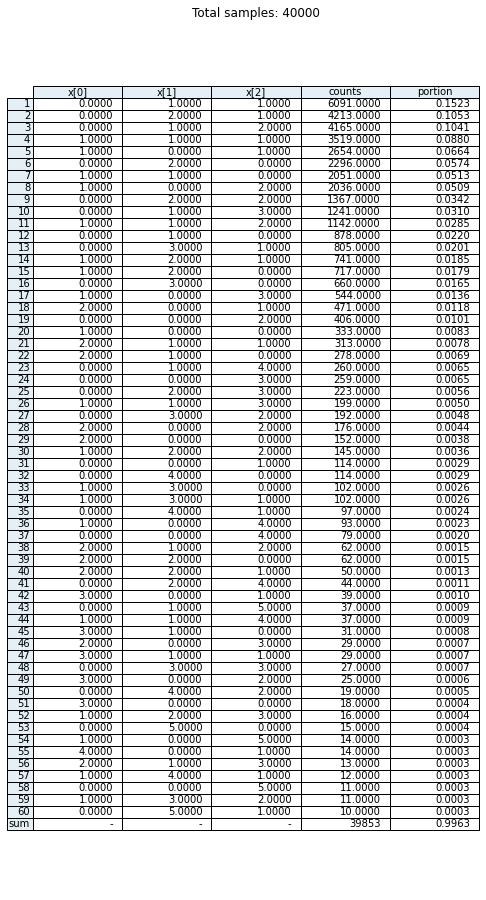

In [97]:
""" Data Analysis """

data_states = train_data[:,1:]
unique_states,counts = np.unique(data_states, axis=0, return_counts=True)
portions = counts/len(data_states)
unique_states = np.append(unique_states, counts.reshape((len(counts),1)), axis=1)
unique_states = np.append(unique_states, portions.reshape((len(portions),1)), axis=1)
unique_states = sorted(unique_states,key=lambda l:l[-1], reverse=True)
counts = np.sort(counts,axis=None)
counts = counts[::-1]
counts = counts.tolist()
portions = np.sort(portions,axis=None)
portions = portions[::-1]
portions = portions.tolist()

NUM = 60

sum_counts = np.sum(counts[:NUM])
sum_portions = np.sum(portions[:NUM])
column_headers = ['x[0]','x[1]','x[2]','counts','portion']
row_headers = [str(n+1) for n in range(NUM)]
cell_text = [[f'{item:3.4f}' for item in unique_state.tolist()] for unique_state in unique_states[0:NUM]]
row_headers.append('sum')
cell_text.append(['-','-','-',sum_counts,f'{sum_portions:3.4f}'])

fig, ax =plt.subplots(figsize=(8,16))
ax.set_axis_off()
rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))
the_table = ax.table(cellText=cell_text,
                            rowLabels=row_headers,
                            rowColours=rcolors,
                            rowLoc='right',
                            colColours=ccolors,
                            colLabels=column_headers,
                            loc='center')

_ = ax.set_title("Total samples: "+ str(len(data_states)))


In [92]:
""" Data Analysis """

def analyze_conditioned(model,gmm_model,train_data,cond_state=[0,1,7],file_addr='../../data/cond_records_[0_1_7]_92M.mat',quantiles=[0.8,1-1e-1,1-1e-3,1-1e-5,1-1e-7]):
    
    #matds = MatlabDatasetH5('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
    cond_matds = MatlabDatasetH5(file_addr)
    #cond_state = [0,1,7]
    test_data = cond_matds.get_data(cond_matds.n_records)

    #fig, ax = plt.subplots(figsize=(9*2,6+3))
    #fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(9*2,6+3))
    fig, axs = plt.subplots(3, 2, figsize=(9*2,6+3+3), gridspec_kw={'height_ratios': [2, 1, 1]})

    # create x
    measured_p0,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=0)
    measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
    measured_p1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
    width = 0.1
    xlim = [np.floor(measured_p0),np.ceil(measured_p1+1),np.ceil(measured_p8),np.ceil(measured_p1+1)]
    if(xlim[0]<=0.1):
        xlim[0] = 0.1
    x = np.arange(start=xlim[0], stop=xlim[1], step=width)
    x_edges = x-(width/2)
    x_edges = np.append(x_edges,x[-1]+(width/2))

    # train data histogram
    try:
        tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
        edataset = train_data
        conditioned_ds = edataset[np.where(np.all(edataset[:,1:]==cond_state,axis=1))]
        conditioned_ds = conditioned_ds[:,0]
        train_hist, bin_edges = np.histogram(conditioned_ds, bins=x_edges, density=True)
        axs[0,0].plot(x,train_hist, marker='.', label="empirical train "+str(num_samples_train), linestyle = ':')
    except:
        num_samples_train = 0

    #x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=60)

    # test data histogram
    edataset = test_data
    conditioned_ds = edataset[np.where(np.all(edataset[:,1:]==cond_state,axis=1))]
    conditioned_ds = conditioned_ds[:,0]
    test_hist, bin_edges = np.histogram(conditioned_ds, bins=x_edges, density=True)
    axs[0,0].plot(x,test_hist, marker='.', label="empirical histogram samples: "+str(num_samples_test), linestyle = ':')
    hist_mean = np.sum(x*test_hist*width)
    #print("empirical mean: " + str(np.sum(x*test_hist*width)))

    # emm model pdf
    prob_emm=[]
    for i in range(len(x)):
        mx = np.array([cond_state])
        my = np.array([x[i]])
        prob_emm.append(model.pdf(mx,my))
    tail_threshold, tail_param = model._get_tail_components(mx)
    tail_threshold = np.squeeze(tail_threshold)
    axs[0,0].plot(x,prob_emm, label="EMM threshold=" + str(tail_threshold))
    emm_mean = np.sum(x*np.squeeze(prob_emm)*width)
    #print("emm mean: " + str(np.sum(x*np.squeeze(prob_emm)*width)))

    # gmm model pdf
    conds = np.array([cond_state for _ in range(len(x))])
    prob_gmm = gmm_model.pdf(conds, x)
    axs[0,0].plot(x,prob_gmm, label="GMM") #substitute actual plotting here
    gmm_mean = np.sum(x*prob_gmm*width)
    #print("gmm mean: " + str(np.sum(x*prob_gmm*width)))

    axs[0,0].set_xlabel('latency [time]')
    #ax.set_xticks([5,6,7,8,9,10])
    #ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[0,0].set_ylabel('probability')
    axs[0,0].set_title("state: " +str(cond_state)+ " training samples: "+ str(num_samples_train))
    axs[0,0].legend()
    axs[0,0].grid()

    x = np.logspace(math.log10( xlim[2] ), math.log10( xlim[3] ), num=60)

    # train data tail
    if(num_samples_train != 0):
        train_tail=[]
        for i in range(len(x)):
            train_tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))
        axs[0,1].loglog(x,train_tail, marker='.', label="empirical train "+str(num_samples_train), linestyle = 'None') 

    # test data tail
    testd_sorted = np.sort(test_data[:,0])
    test_tail=[]
    for i in range(len(x)):
        indx = bisect.bisect_left(testd_sorted, x[i])
        test_tail.append((len(test_data)-indx)/len(test_data))
    axs[0,1].loglog(x,test_tail, marker='.', label="empirical test "+str(num_samples_test), linestyle = 'None')

    # emm tail
    emm_tail=[]
    for i in range(len(x)):
        mx = np.array([cond_state])
        my = np.array([x[i]])
        emm_tail.append(model.tail(mx,my))
    tail_threshold, tail_param = model._get_tail_components(mx)
    tail_threshold = np.squeeze(tail_threshold)
    axs[0,1].loglog(x,emm_tail, label="EMM threshold=" + str(tail_threshold))

    # gmm tail
    gmm_tail=[]
    for i in range(len(x)):
        gmm_tail.append(gmm_model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))
    axs[0,1].loglog(x,gmm_tail, label="GMM")

    axs[0,1].set_xlabel('latency [log]')
    axs[0,1].set_ylabel('Tail probability: 1-F(x) [log]')
    axs[0,1].set_title("state: " +str(cond_state)+ " training samples: "+ str(num_samples_train))
    axs[0,1].legend()
    axs[0,1].grid()

    # table

    test_quants = []
    num_sample_quants = []
    for quant in quantiles:
        test_perc,_,_ = measure_percentile_allsame(dataset=test_data,p_perc=quant*100)
        num_sampletest = len(test_data[test_data>=test_perc])
        test_quants.append(test_perc)
        num_sample_quants.append(num_sampletest)


    emm_quants = []
    gmm_quants = []
    cstate = np.array([cond_state])
    for quant in quantiles:
        emm_quants.append(model.find_perc(alpha=1-quant,eps=1e-2,x_cond=cstate,init_bound=200))
        gmm_quants.append(gmm_model.find_perc(alpha=1-quant,eps=1e-2,x_cond=cstate,init_bound=200))


    row_headers = ['empirical','emp samples','EMM','GMM']
    column_headers = ['mean']
    cell_text = [[f'{hist_mean:3.3f}']+['']*len(test_quants),
                 [str(num_samples_test)]+['']*len(test_quants),
                 [f'{emm_mean:3.3f}']+['']*len(test_quants),
                 [f'{gmm_mean:3.3f}']+['']*len(test_quants)]
    for i in range(len(test_quants)):
        column_headers.append(str(quantiles[i]))
        cell_text[0][i+1] = f'{test_quants[i]:3.3f}'
        cell_text[1][i+1] = str(num_sample_quants[i])
        cell_text[2][i+1] = f'{emm_quants[i]:3.3f}'
        cell_text[3][i+1] = f'{gmm_quants[i]:3.3f}'

    rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))
    the_table = axs[1,0].table(cellText=cell_text,
                                rowLabels=row_headers,
                                rowColours=rcolors,
                                rowLoc='right',
                                colColours=ccolors,
                                colLabels=column_headers,
                                loc='center')


    # Hide table axes
    axs[1,0].get_xaxis().set_visible(False)
    axs[1,0].get_yaxis().set_visible(False)
    # Hide table axes border
    axs[1,0].spines["top"].set_visible(False)
    axs[1,0].spines["right"].set_visible(False)
    axs[1,0].spines["left"].set_visible(False)
    axs[1,0].spines["bottom"].set_visible(False)

    # tail error plot
    gmmt = np.array(gmm_tail[0:len(test_tail)])
    emmt = np.array(emm_tail[0:len(test_tail)])
    gmm_error = np.log10(gmmt)-np.log10(test_tail)
    emm_error = np.log10(emmt)-np.log10(test_tail)
    axs[1,1].plot(x,gmm_error, label="GMM")
    axs[1,1].plot(x,emm_error, label="EMM")
    axs[1,1].set_xscale('log')
    axs[1,1].set_xlabel('latency [log]')
    axs[1,1].set_ylabel('Tail probability error [log]')
    axs[1,1].legend()
    axs[1,1].grid()

    #bar plot
    labels = column_headers
    #labels = ['mean','0.8','1-$10^{-1}$','1-$10^{-3}$','1-$10^{-5}$','1-$10^{-7}$']
    emm_norm = [emm_mean/hist_mean]
    gmm_norm = [gmm_mean/hist_mean]
    for i in range(len(test_quants)):
        emm_norm.append(emm_quants[i]/test_quants[i])
        gmm_norm.append(gmm_quants[i]/test_quants[i])
    
    #emm_norm = [emm_mean/hist_mean, emm_perc_p80/test_perc_p80, emm_perc_p99/test_perc_p99, emm_perc_p9_3/test_perc_p9_3, emm_perc_p9_5/test_perc_p9_5, emm_perc_p9_7/test_perc_p9_7]
    #gmm_norm = [gmm_mean/hist_mean, gmm_perc_p80/test_perc_p80, gmm_perc_p99/test_perc_p99, gmm_perc_p9_3/test_perc_p9_3, gmm_perc_p9_5/test_perc_p9_5, gmm_perc_p9_7/test_perc_p9_7]

    xbar = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    rects1 = axs[2,0].bar(xbar + width/2, emm_norm, width, label='EMM')
    rects2 = axs[2,0].bar(xbar - width/2, gmm_norm, width, label='GMM')
    xhl = np.arange(len(labels)+2)-1
    h_line = [1 for _ in xhl]
    axs[2,0].plot(xhl,h_line, label='Target')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    axs[2,0].set_ylabel('standardized quantiles')
    axs[2,0].set_title('Standardized estimated quantiles')
    axs[2,0].set_xticks(xbar)
    axs[2,0].set_xticklabels(labels)
    axs[2,0].legend()

    #axs[2,0].bar_label(rects1, padding=3)
    #axs[2,0].bar_label(rects2, padding=3)

    plt.show()


 Dataset H5 loaded from .mat file. Rows: 3543194   Columns: 4 


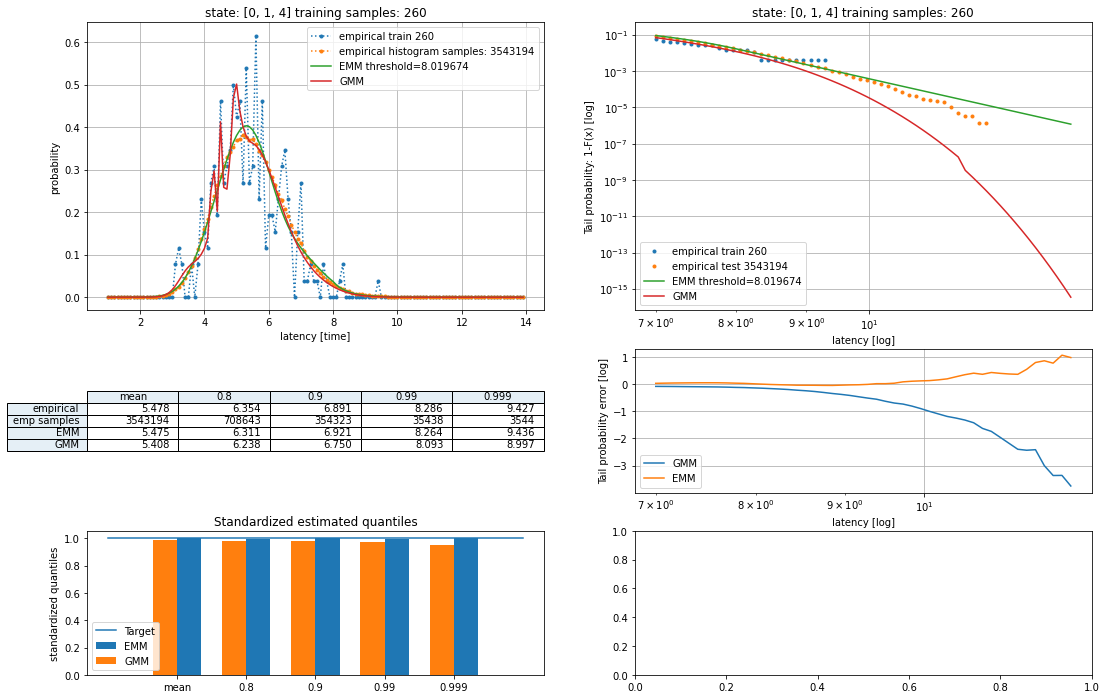

 Dataset H5 loaded from .mat file. Rows: 12051   Columns: 4 


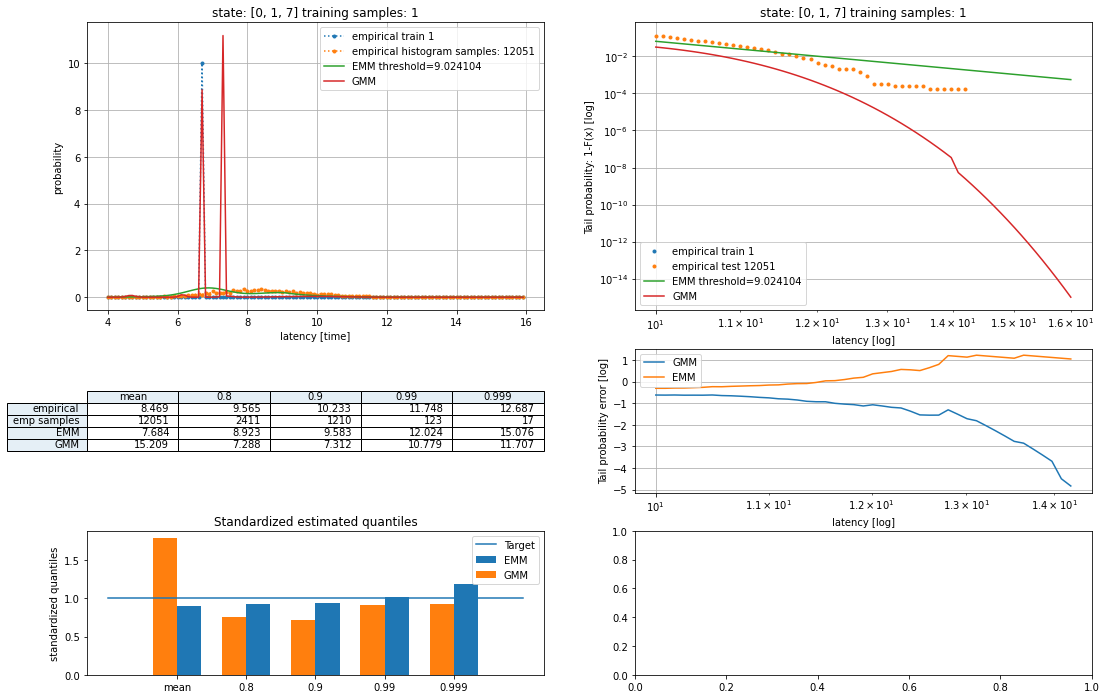

In [93]:
import warnings
warnings.filterwarnings('ignore')

analyze_conditioned(model=model,gmm_model=gmm_model,train_data=train_data,cond_state=[0,1,4],file_addr='../../data/cond_records_[0_1_4]_92M.mat',quantiles=[0.8,1-1e-1,1-1e-2,1-1e-3])
analyze_conditioned(model=model,gmm_model=gmm_model,train_data=train_data,cond_state=[0,1,7],file_addr='../../data/cond_records_[0_1_7]_92M.mat',quantiles=[0.8,1-1e-1,1-1e-2,1-1e-3])

 Dataset H5 loaded from .mat file. Rows: 92127736   Columns: 4 


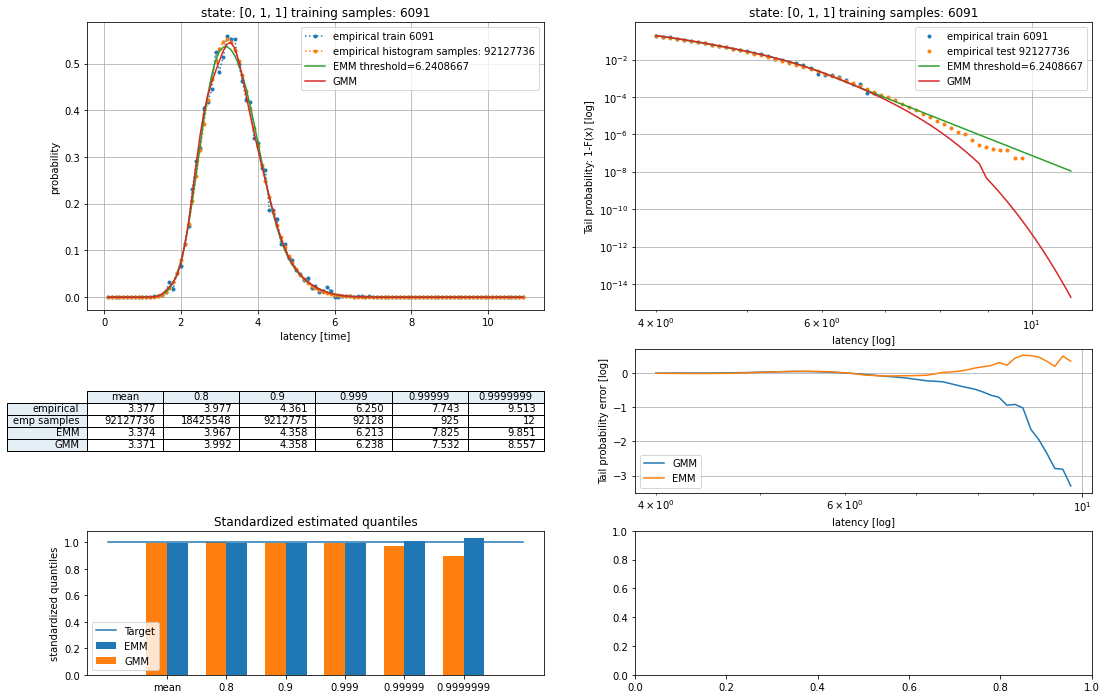

 Dataset H5 loaded from .mat file. Rows: 65538430   Columns: 4 


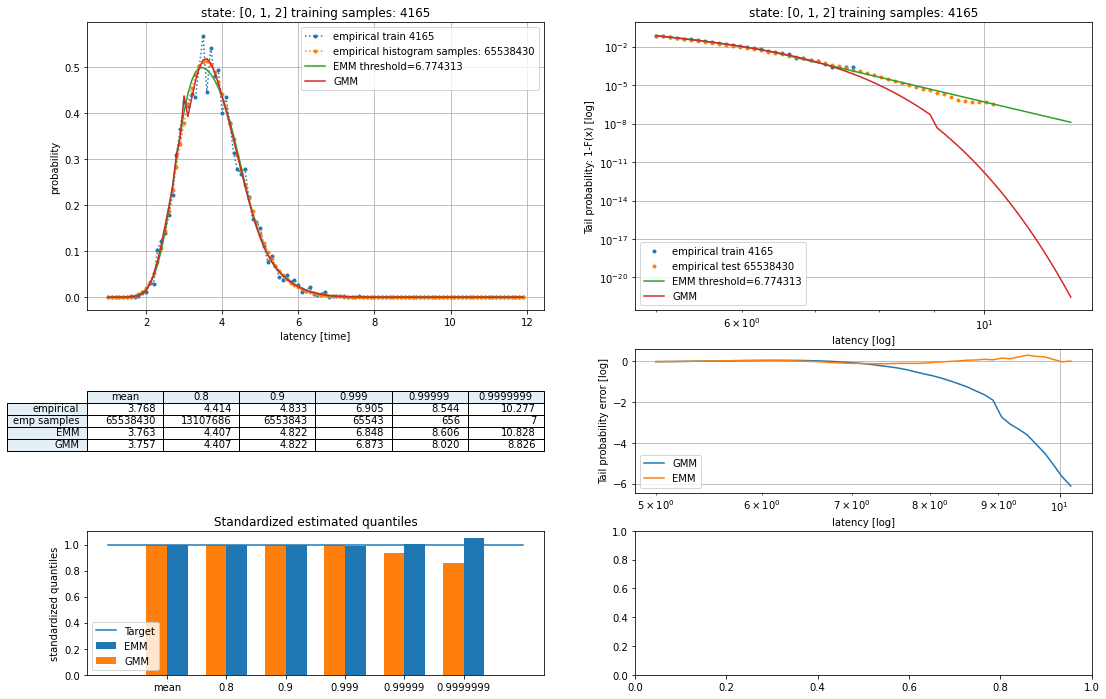

 Dataset H5 loaded from .mat file. Rows: 64248362   Columns: 4 


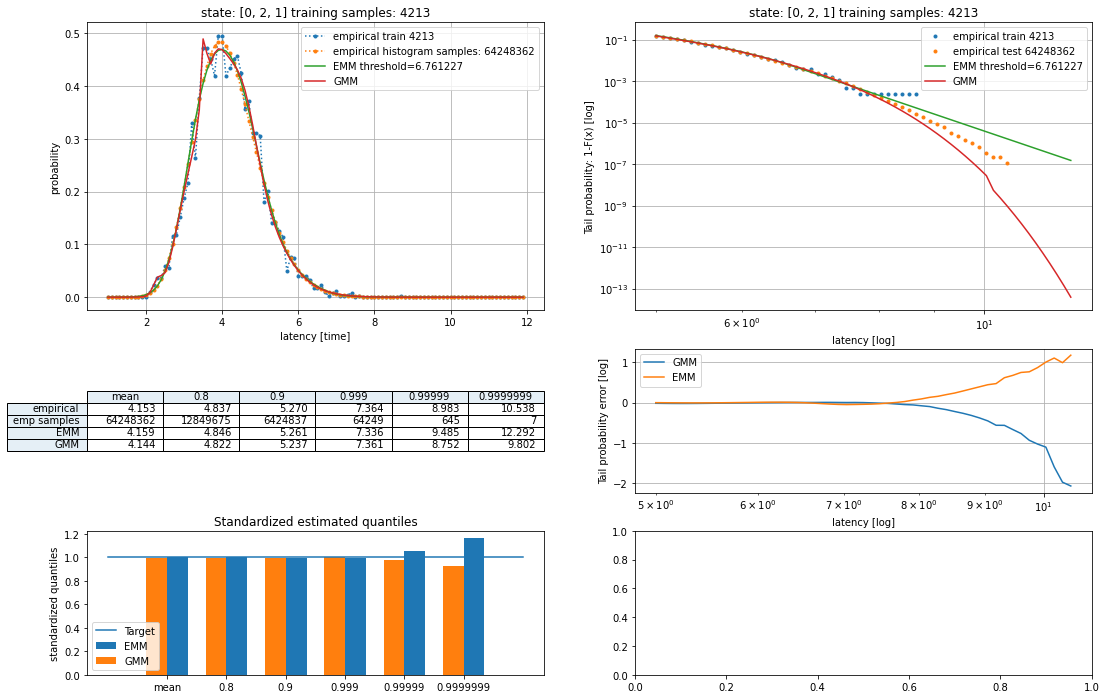

 Dataset H5 loaded from .mat file. Rows: 55503665   Columns: 4 


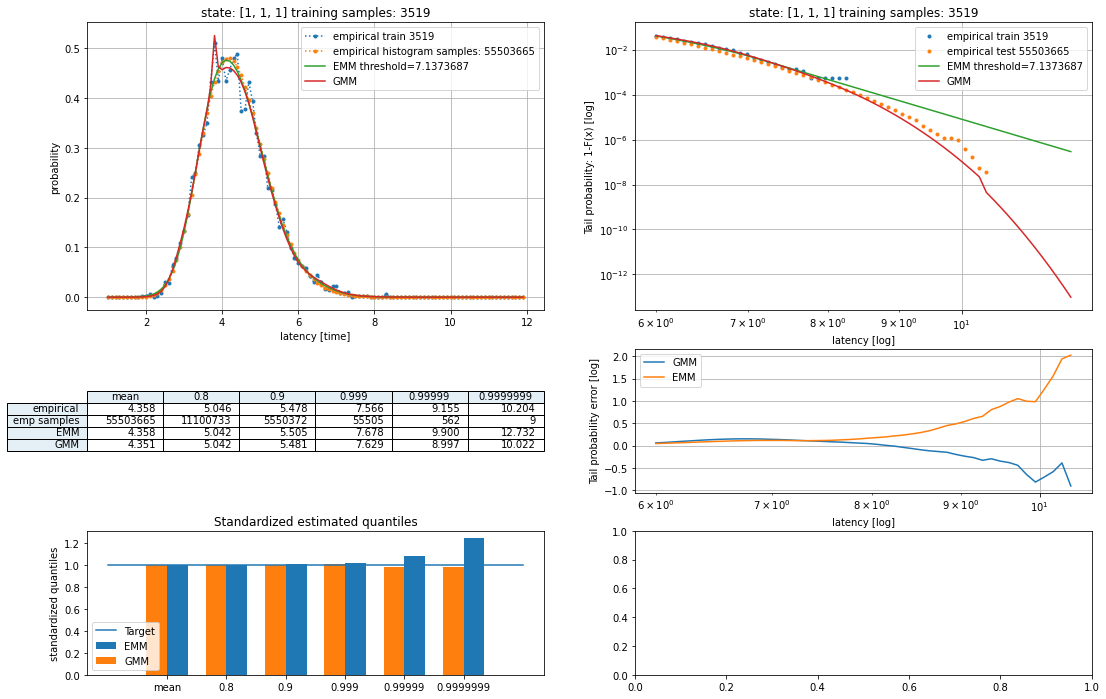

In [94]:
analyze_conditioned(model=model,gmm_model=gmm_model,train_data=train_data,cond_state=[0,1,1],file_addr='../../data/cond_records_[0_1_1]_92M.mat',quantiles=[0.8,1-1e-1,1-1e-3,1-1e-5,1-1e-7])
analyze_conditioned(model=model,gmm_model=gmm_model,train_data=train_data,cond_state=[0,1,2],file_addr='../../data/cond_records_[0_1_2]_92M.mat',quantiles=[0.8,1-1e-1,1-1e-3,1-1e-5,1-1e-7])
analyze_conditioned(model=model,gmm_model=gmm_model,train_data=train_data,cond_state=[0,2,1],file_addr='../../data/cond_records_[0_2_1]_92M.mat',quantiles=[0.8,1-1e-1,1-1e-3,1-1e-5,1-1e-7])
analyze_conditioned(model=model,gmm_model=gmm_model,train_data=train_data,cond_state=[1,1,1],file_addr='../../data/cond_records_[1_1_1]_92M.mat',quantiles=[0.8,1-1e-1,1-1e-3,1-1e-5,1-1e-7])

In [5]:
""" Import the test dataset into Numpy array """
import time

# define the test packet stream

start_time = time.time()
# 130 seconds each, 15 minutes total
cond_matds = MatlabDatasetH5(file_address='../../data/package/records_A1.mat',content_key='records_A1',select_cols=[0,1,5,9])
test_data = cond_matds.dataset
cond_matds = MatlabDatasetH5(file_address='../../data/package/records_A2.mat',content_key='records_A2',select_cols=[0,1,5,9])
test_data = np.append(test_data,cond_matds.dataset,axis=0)
cond_matds = MatlabDatasetH5(file_address='../../data/package/records_A3.mat',content_key='records_A3',select_cols=[0,1,5,9])
test_data = np.append(test_data,cond_matds.dataset,axis=0)
cond_matds = MatlabDatasetH5(file_address='../../data/package/records_A4.mat',content_key='records_A4',select_cols=[0,1,5,9])
test_data = np.append(test_data,cond_matds.dataset,axis=0)
cond_matds = MatlabDatasetH5(file_address='../../data/package/records_B1.mat',content_key='records_B1',select_cols=[0,1,5,9])
test_data = np.append(test_data,cond_matds.dataset,axis=0)
cond_matds = MatlabDatasetH5(file_address='../../data/package/records_B2.mat',content_key='records_B2',select_cols=[0,1,5,9])
test_data = np.append(test_data,cond_matds.dataset,axis=0)
cond_matds = MatlabDatasetH5(file_address='../../data/package/records_B3.mat',content_key='records_B3',select_cols=[0,1,5,9])
test_data = np.append(test_data,cond_matds.dataset,axis=0)
cond_matds = MatlabDatasetH5(file_address='../../data/package/records_B4.mat',content_key='records_B4',select_cols=[0,1,5,9])
test_data = np.append(test_data,cond_matds.dataset,axis=0)


elapsed_time = time.time() - start_time
print(f'{elapsed_time:3.1f}')

print(len(test_data))
print(len(test_data[0]))

 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 87999682   Columns: 4 
1764.5
703997456
4


In [6]:
class empirical_measurer():
    def __init__(self, dataset, xsize=3,quantiles=[0.8,0.9,0.99]):
        # x_cond | mean | quantiles | number of samples
        self.database = np.empty((0,xsize+1+len(quantiles)+1))
        self.dataset = dataset
        self.quantiles = quantiles
        self.xsize = xsize

    def query_database(self,x_cond):
        if self.database.size is 0:
            return False, np.array([])
        condition = (self.database[:,:self.xsize]==x_cond)
        index = np.where(condition.all(axis=1))
        if len(index[0]) is 0:
            return False, np.array([])
        else:
            index = np.squeeze(index)
            return True, self.database[index]

    def measure_quantiles(self,x_cond):
        result, entry = self.query_database(x_cond)
        if result is False:
            # calculate the quantiles and mean
            conditioned_ds = np.squeeze(self.dataset[np.where((self.dataset[:,1:]==x_cond).all(axis=1)),0])
            measured_quants = np.quantile(conditioned_ds, self.quantiles)
            mean = np.mean(conditioned_ds)
            # insert the entry to the database
            # x_cond | mean | quantiles | number of samples
            entry = np.concatenate((x_cond,[mean],measured_quants,[len(conditioned_ds)]))
            self.database = np.append(self.database,[entry],axis=0)
        
        return entry[self.xsize:self.xsize+len(self.quantiles)+1],entry[-1]
            

In [180]:
""" empirical_measurer example """

start_time = time.time()
em = empirical_measurer(test_data,3,[0.8,0.9,0.99])
# array(mean,quantiles), number of samples
print(em.measure_quantiles(x_cond=[0,2,7]))
elapsed_time = time.time() - start_time
print(f'{elapsed_time:3.1f}')


(array([ 9.39162425, 10.50903232, 11.04100028, 13.07094351]), 1711.0)
51.6


In [7]:
""" The function to calculate expected value form the trained model """

def obtain_exp_value(model,cond_state):
    width = 0.1
    xlim = [0.1,30]
    x = np.arange(start=xlim[0], stop=xlim[1], step=width)
    # model pdf
    prob=[]
    for i in range(len(x)):
        mx = np.array([cond_state])
        my = np.array([x[i]])
        prob.append(model.pdf(mx,my))

    return np.sum(x*np.squeeze(prob)*width)

In [192]:
""" Example for exp calculation """
print(obtain_exp_value(model,[0,1,1]))
print(obtain_exp_value(gmm_model,[0,1,1]))


3.3582455999353162
3.3690985804293687


In [9]:
""" Evaluation one by one from test dataset"""
""" Requirements: emm, gmm model, and test_data """

N = 2
quantiles = [0.8, 0.9, 0.999, 0.99999]
em = empirical_measurer(dataset=test_data,xsize=3,quantiles=quantiles)
start_time = time.time()

results = np.empty((0,em.xsize+(1+len(quantiles))*2+1))
for n in range(N):
    # check the system state
    x_n = test_data[n,1:]
    #print(x_n)

    # estimate mean and quantiles from the trained models
    ch_emm_n = np.array([obtain_exp_value(model,x_n)])
    ch_gmm_n = np.array([obtain_exp_value(gmm_model,x_n)])
    cstate = np.array([x_n])
    for quant in quantiles:
        #ch_emm_n = np.append(ch_emm_n,model.find_perc(alpha=1-quant,eps=1e-2,x_cond=cstate,init_bound=200))
        ch_emm_n = np.append(ch_emm_n,model.tail_inverse(X=cstate,T=1-quant,init_bound=200,eps=1e-2))
        ch_gmm_n = np.append(ch_gmm_n,gmm_model.find_perc(alpha=1-quant,eps=1e-2,x_cond=cstate,init_bound=200))
    
    #print(ch_emm_n)
    #print(ch_gmm_n)

    # calculate quantiles from empirical data
    c_n, test_samples_n = em.measure_quantiles(x_cond=x_n)
    #print(c_n)
    
    entry = np.concatenate((x_n,(ch_emm_n-c_n)/c_n,(ch_gmm_n-c_n)/c_n,[test_samples_n]))
    #print(entry)

    #print(test_samples_n)
    results = np.append(results,[entry],axis=0)

elapsed_time = time.time() - start_time
print(f'{elapsed_time:3.1f}')


180.5


In [102]:
""" Evaluation one by one from processed data"""
""" Requirements: emm, gmm model, test_data, and unique_states """

N = 60
quantiles = [0.9, 0.99, 0.999, 0.9999, 0.99999]
xsize = 3
em = empirical_measurer(dataset=test_data,xsize=xsize,quantiles=quantiles)
unique_states_np = np.array(unique_states)
start_time = time.time()

#results = np.empty((0,em.xsize+(1+len(quantiles))*2+1)) # with mean
results = np.empty((0,em.xsize+(len(quantiles))*2+1)) # without mean
for n in range(N):
    # check the system state
    x_n = unique_states_np[n,:xsize]
    #print(x_n)

    # estimate mean and quantiles from the trained models
    #ch_emm_n = np.array([obtain_exp_value(model,x_n)])
    #ch_gmm_n = np.array([obtain_exp_value(gmm_model,x_n)])
    # temp: no mean
    ch_emm_n = np.array([])
    ch_gmm_n = np.array([])
    cstate = np.array([x_n])
    for quant in quantiles:
        #ch_emm_n = np.append(ch_emm_n,model.find_perc(alpha=1-quant,eps=1e-2,x_cond=cstate,init_bound=200))
        ch_emm_n = np.append(ch_emm_n,model.tail_inverse(X=cstate,T=1-quant,init_bound=200,eps=1e-2))
        ch_gmm_n = np.append(ch_gmm_n,gmm_model.find_perc(alpha=1-quant,eps=1e-2,x_cond=cstate,init_bound=200))
    
    #print(ch_emm_n)
    #print(ch_gmm_n)

    # calculate quantiles from empirical data
    c_n, test_samples_n = em.measure_quantiles(x_cond=x_n)
    # no mean
    c_n = c_n[1:]
    #print(c_n)
    
    entry = np.concatenate((x_n,(ch_emm_n-c_n)/c_n,(ch_gmm_n-c_n)/c_n,[test_samples_n/len(test_data)]))
    #print(entry)

    #print(test_samples_n)
    results = np.append(results,[entry],axis=0)

elapsed_time = time.time() - start_time
print(f'{elapsed_time:3.1f}')
print(results)


5856.4
[[ 0.00000000e+00  1.00000000e+00  1.00000000e+00 -8.11952245e-04
   8.22111176e-03 -5.84800782e-03 -8.51687641e-03  8.49866074e-03
  -8.11952245e-04  8.22111176e-03 -1.94171316e-03 -1.89352630e-02
  -2.92610395e-02  1.49559238e-01]
 [ 0.00000000e+00  2.00000000e+00  1.00000000e+00 -1.61088324e-03
   2.36851008e-03 -3.30123197e-03  1.75636484e-02  5.67582438e-02
  -6.24377937e-03  2.36851008e-03  1.55692501e-05 -9.25354873e-03
  -2.48447094e-02  1.04300371e-01]
 [ 0.00000000e+00  1.00000000e+00  2.00000000e+00 -2.22572722e-03
   9.72176324e-03 -8.27161452e-03 -1.02381424e-02  8.04477573e-03
  -2.22572722e-03  9.72176324e-03 -4.73604095e-03 -3.22678180e-02
  -6.05880601e-02  1.06392656e-01]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  4.96683018e-03
   1.62312369e-02  1.45353423e-02  3.38311649e-02  7.75762971e-02
   5.10214524e-04  2.36085961e-02  8.08360723e-03 -3.86814826e-03
  -2.07475573e-02  9.01052304e-02]
 [ 1.00000000e+00  0.00000000e+00  1.00000000e+00 -7.43060357

Text(0.5, 0.98, 'Trained with 40K samples')

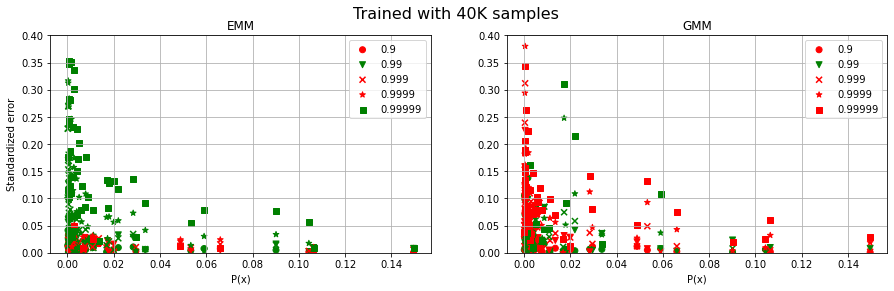

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
colors_arr = np.where(results[:,3] > 0, 'green', 'red')
path = axes[0].scatter(results[:,-1],abs(results[:,3]),c=colors_arr,marker='o')
colors_arr = np.where(results[:,4] > 0, 'green', 'red')
path = axes[0].scatter(results[:,-1],abs(results[:,4]),c=colors_arr,marker='v')
colors_arr = np.where(results[:,5] > 0, 'green', 'red')
path = axes[0].scatter(results[:,-1],abs(results[:,5]),c=colors_arr,marker='x')
colors_arr = np.where(results[:,6] > 0, 'green', 'red')
path = axes[0].scatter(results[:,-1],abs(results[:,6]),c=colors_arr,marker='*')
colors_arr = np.where(results[:,7] > 0, 'green', 'red')
path = axes[0].scatter(results[:,-1],abs(results[:,7]),c=colors_arr,marker='s')
leg = axes[0].legend([str(quantiles[0]),str(quantiles[1]),str(quantiles[2]),str(quantiles[3]),str(quantiles[4])])
axes[0].set_ylim([0,0.4])
axes[0].grid()
axes[0].set_title('EMM')
axes[0].set_ylabel('Standardized error')
axes[0].set_xlabel('P(x)')

colors_arr = np.where(results[:,8] > 0, 'green', 'red')
path = axes[1].scatter(results[:,-1],abs(results[:,8]),c=colors_arr,marker='o')
colors_arr = np.where(results[:,9] > 0, 'green', 'red')
path = axes[1].scatter(results[:,-1],abs(results[:,9]),c=colors_arr,marker='v')
colors_arr = np.where(results[:,10] > 0, 'green', 'red')
path = axes[1].scatter(results[:,-1],abs(results[:,10]),c=colors_arr,marker='x')
colors_arr = np.where(results[:,11] > 0, 'green', 'red')
path = axes[1].scatter(results[:,-1],abs(results[:,11]),c=colors_arr,marker='*')
colors_arr = np.where(results[:,12] > 0, 'green', 'red')
path = axes[1].scatter(results[:,-1],abs(results[:,12]),c=colors_arr,marker='s')
leg = axes[1].legend([str(quantiles[0]),str(quantiles[1]),str(quantiles[2]),str(quantiles[3]),str(quantiles[4])])
axes[1].set_ylim([0,0.4])
axes[1].grid()
axes[1].set_title('GMM')
axes[1].set_xlabel('P(x)')

fig.suptitle('Trained with 40K samples', fontsize=16)


In [ ]:
# instead of P(x) -> training samples [log scale]
# legend shapes -> no color
# deviation from ground truth
# y axis -> [log]
# try GPD at the tail
# Related work
# Aggregate error for each quantile
# Underestimation figure -> its a problem
# write-up
# 4k, 40k, 400k, and other service processes